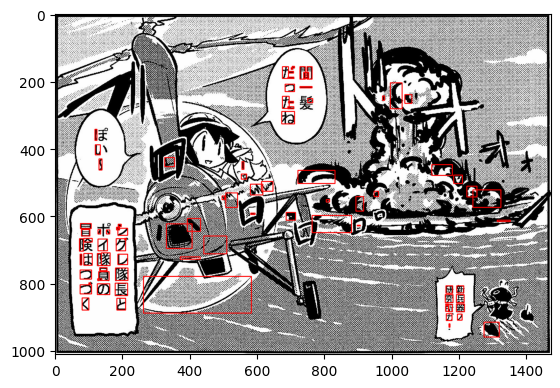

In [1]:
import cv2
from matplotlib import pyplot as plt

sample_input = '/home/saratoga/Manga-Text-Segmentation/images/shegreat_0020.png'
sample_input_line = '/home/saratoga/swt2_data/line.png'

img = cv2.imread(sample_input)
line = cv2.imread(sample_input_line)
rects, draw, chainBBs = cv2.text.detectTextSWT(line, True)
for rect in rects:
    cv2.rectangle(img, rect, (255,0,0), 2)
plt.imshow(img)

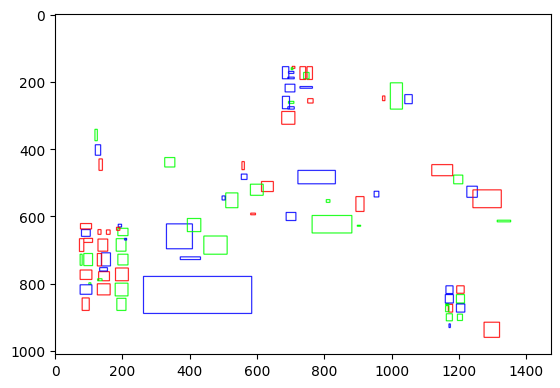

In [2]:
plt.imshow(draw)

In [3]:
import numpy as np
db_model_path = "swt2/DB_TD500_resnet50.onnx"
# model.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
# model.setPreferableTarget(cv2.dnn.DNN_BACKEND_CUDA)

[0.55523944 0.91485864 0.6063983  0.73983586 0.66866285 0.6995204
 0.51944727 0.76907164 0.7773897  0.7726255  0.88150185]


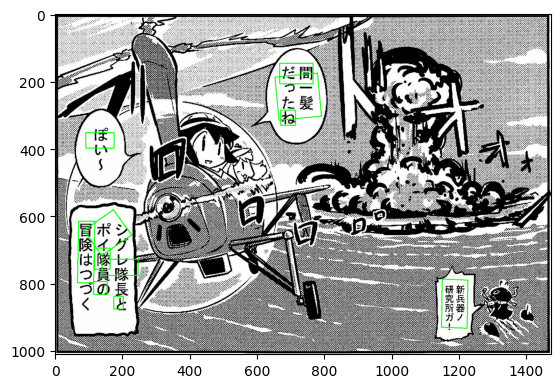

In [4]:
model = cv2.dnn.TextDetectionModel_DB(db_model_path)
model.setBinaryThreshold(0.3).setPolygonThreshold(0.5).setMaxCandidates(200).setUnclipRatio(2.0)
# model.setPolygonThreshold(0.8)
# model.setBinaryThreshold(0.5)
scale = 1. / 255.0
mean = (122.67891434, 116.66876762, 104.00698793)
# mean = (30, 0, 30)
model.setInputParams(scale, (736, 736), mean, False, False)

img2 = cv2.imread(sample_input)
height, width, channel = img2.shape
# print(width, height)
# img2 = img2[:, :height]

results, confidences = model.detect(img2)
print(confidences)

# Visualize
# blank = np.ndarray(img2.shape, dtype=img2.dtype)
cv2.polylines(img2, results, True, (0, 255, 0), 2)
plt.imshow(img2)

[0.9993704 0.9959558 0.9793864 0.9214715]


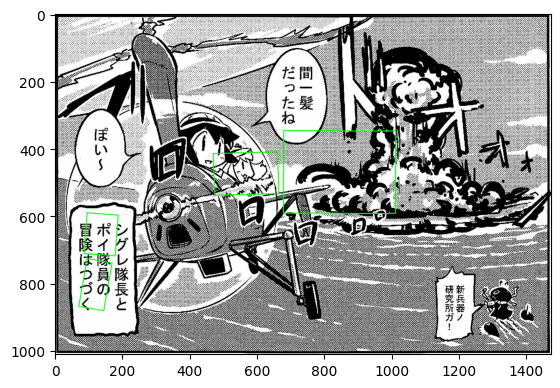

In [5]:
model2 = cv2.dnn.TextDetectionModel_EAST("swt2/frozen_east_text_detection.pb")
 
confThreshold = 0.5
nmsThreshold = 0.4
model2.setConfidenceThreshold(confThreshold).setNMSThreshold(nmsThreshold)

detScale = 1.0
detInputSize = (320, 320)
detMean = (123.68, 116.78, 103.94)
swapRB = True
model2.setInputParams(detScale, detInputSize, detMean, swapRB)

img3 = cv2.imread(sample_input)
results, confidences = model2.detect(img2)
print(confidences)

# Visualize
# blank = np.ndarray(img2.shape, dtype=img2.dtype)
cv2.polylines(img3, results, True, (0, 255, 0), 2)
plt.imshow(img3)

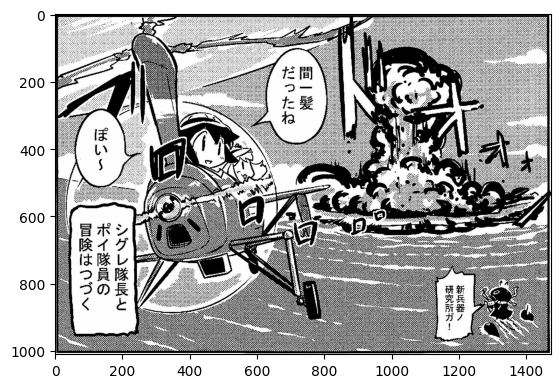

In [6]:
img4 = cv2.imread(sample_input)
# https://github.com/opencv/opencv_contrib/blob/4.x/modules/text/samples/deeptextdetection.py
textSpotter = cv2.text.TextDetectorCNN_create("swt2/textbox.prototxt", "swt2/TextBoxes_icdar13.caffemodel")
rects, outProbs = textSpotter.detect(img4)
thres = 0.5

for r in range(np.shape(rects)[0]):
    if outProbs[r] > thres:
        rect = rects[r]
        cv2.rectangle(img4, (rect[0],rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (255, 0, 0), 2)
plt.imshow(img4)

Extracting Class Specific Extremal Regions from 9 channels ...
    (...) this may take a while (...)


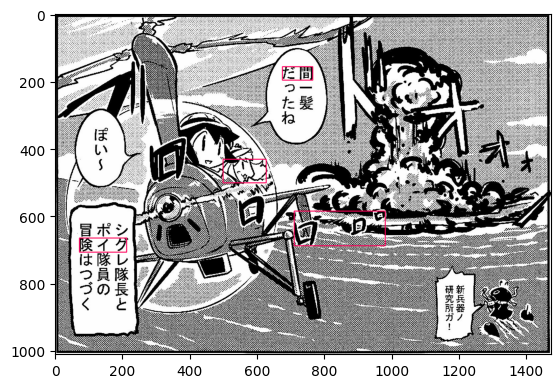

In [7]:
# https://github.com/opencv/opencv_contrib/blob/4.x/modules/text/samples/textdetection.py
img5 = cv2.imread(sample_input)
# Extract channels to be processed individually
channels = list(cv2.text.computeNMChannels(img5))
# Append negative channels to detect ER- (bright regions over dark background)
cn = len(channels)-1
for c in range(0,cn):
    channels.append(255-channels[c])

# Apply the default cascade classifier to each independent channel (could be done in parallel)

erc1 = cv2.text.loadClassifierNM1('swt2/trained_classifierNM1.xml')
er1 = cv2.text.createERFilterNM1(erc1,16,0.00015,0.13,0.2,True,0.1)

erc2 = cv2.text.loadClassifierNM2('swt2/trained_classifierNM2.xml')
er2 = cv2.text.createERFilterNM2(erc2,0.5)

print("Extracting Class Specific Extremal Regions from "+str(len(channels))+" channels ...")
print("    (...) this may take a while (...)")
for channel in channels:

    regions = cv2.text.detectRegions(channel,er1,er2)
    
    rects = cv2.text.erGrouping(img5,channel,[r.tolist() for r in regions])
    #rects = cv2.text.erGrouping(img,channel,[x.tolist() for x in regions], cv2.text.ERGROUPING_ORIENTATION_ANY,'swt2/trained_classifier_erGrouping.xml',0.5)
    
    #Visualization
    for rect in rects:
        cv2.rectangle(img5, (rect[0],rect[1]), (rect[0]+rect[2],rect[1]+rect[3]), (255, 0, 0), 2)
        cv2.rectangle(img5, (rect[0],rect[1]), (rect[0]+rect[2],rect[1]+rect[3]), (255, 0, 255), 1)
plt.imshow(img5)

In [8]:
# https://github.com/opencv/opencv_contrib/blob/master/modules/text/samples/cropped_word_recognition.cpp
# https://github.com/opencv/opencv_contrib/blob/master/modules/text/samples/character_recognition.cpp